# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv("C:/Users/David/Documents/GitHub/Quantitative_Trading_Algorithm/output.csv")

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year',
    'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'date', 'year', 'month', 'day', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Preprocess and Feature Engineering

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Custom Train-Test Split for LSTM To Keep Data Sequential

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

def custom_train_test_split_with_indices(features, target, sequence_length=10, test_size=0.2):
    # Create sequences
    sequences = []
    labels = []
    indices = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        labels.append(target[i+sequence_length])
        indices.append(i+sequence_length)
    
    X = np.array(sequences)
    y = np.array(labels)
    indices = np.array(indices)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, indices, test_size=test_size, random_state=42
    )
    
    # Reshape data for LSTM (needs 3D input: [samples, time steps, features])
    X_train_lstm_prepared = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test_lstm_prepared = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    y_train_lstm_prepared = y_train
    y_test_lstm_prepared = y_test
    
    return (X_train_lstm_prepared, y_train_lstm_prepared, train_indices,
            X_test_lstm_prepared, y_test_lstm_prepared, test_indices)

# Use the function
X_train_lstm_prepared, y_train_lstm_prepared, train_indices, X_test_lstm_prepared, y_test_lstm_prepared, test_indices = custom_train_test_split_with_indices(features_scaled, target)

## Model Implementation

### Feed-Forward Neural Network (FFNN)

Epoch 1/400


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3424986.7500 - val_loss: 3773992.7500
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3631911.2500 - val_loss: 3555226.2500
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3407973.5000 - val_loss: 3161476.5000
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3011024.0000 - val_loss: 2587196.5000
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2220928.5000 - val_loss: 1878488.0000
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1673681.3750 - val_loss: 1164189.6250
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1038359.0000 - val_loss: 553166.8750
Epoch 8/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 524353.6250 - val_loss: 221927.1406
Epoch 9/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 241172.0469 - val_loss: 142676.0312
Epoch 10/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164186.3906 - val_loss: 111148.9766
Epoch 11/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

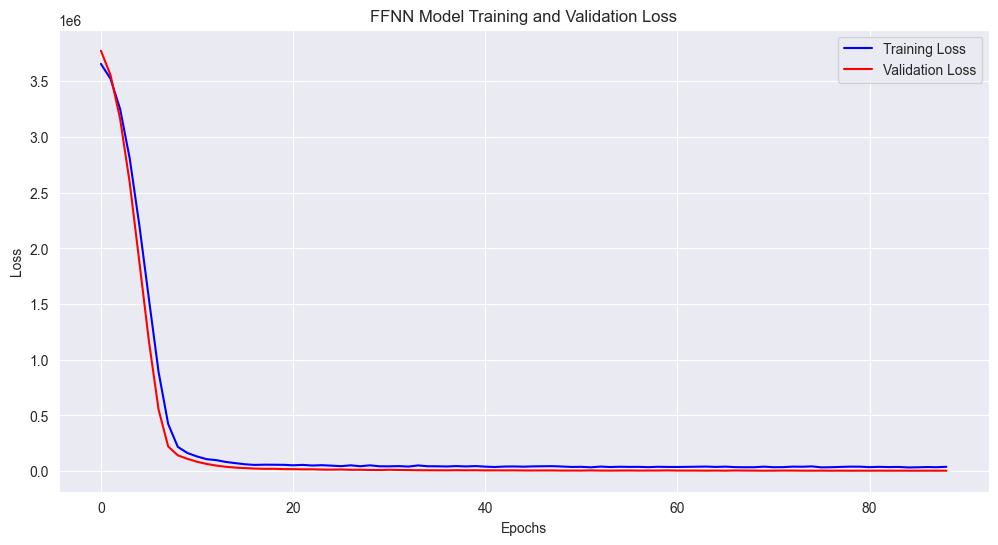

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

# Define the FFNN model creation function

def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(ffnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('FFNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Long Short-Term Memory Network (LSTM)

Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3660299.5000 - val_loss: 3896417.2500
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3680605.5000 - val_loss: 3812809.7500
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3928338.0000 - val_loss: 3659376.2500
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3683195.7500 - val_loss: 3392988.2500
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3542807.5000 - val_loss: 3188104.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3064036.2500 - val_loss: 2894249.2500
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2647036.5000 - val_loss: 2316399.5000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2331737.2500 - val_loss: 1866650.6250
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1864227.5000 - val_loss: 1684036.2500
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1350401.6250 - val_loss: 1026403.5000
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

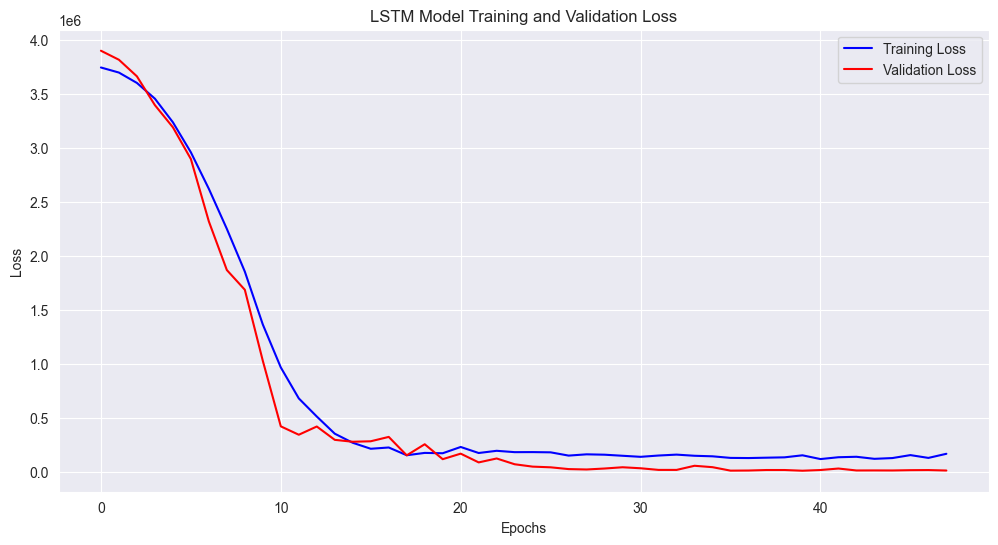

In [32]:
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.3))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm_prepared.shape[1], X_train_lstm_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm_prepared, y_train_lstm_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm_prepared, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm_prepared)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Convolutional Neural Network (CNN)

Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3023889.7500 - val_loss: 985578.3750
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 853150.3125 - val_loss: 301577.0000
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 274076.0625 - val_loss: 158109.8594
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 159881.2344 - val_loss: 118321.9609
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 116757.1250 - val_loss: 96952.5703
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 99934.5234 - val_loss: 81588.8984
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86749.4375 - val_loss: 72185.6953
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75375.6875 - val_loss: 60755.8867
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65766.5078 - val_loss: 50144.1211
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52568.7148 - val_loss: 43101.3047
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46451.7031 - val_loss

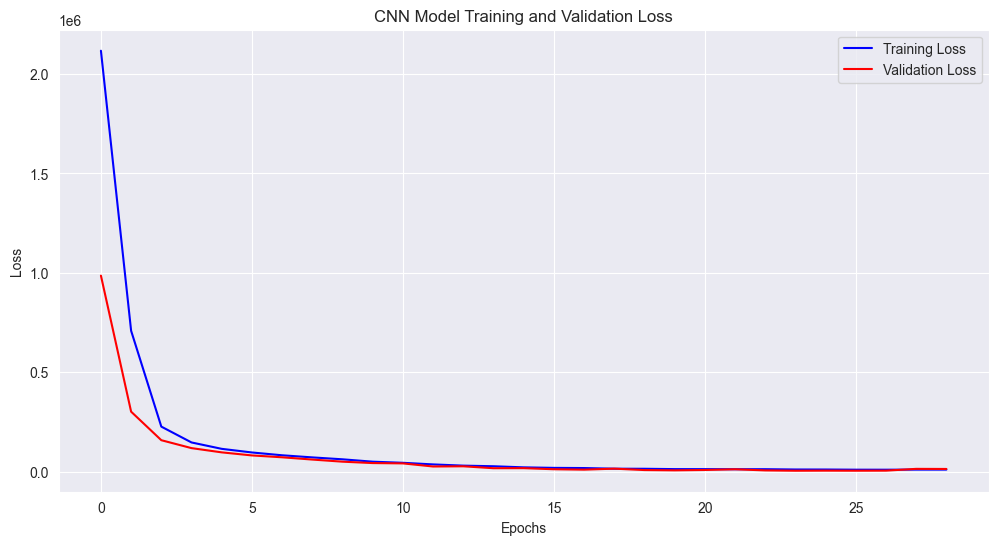

In [33]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")

plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Auto-encoder

Different data pre-rocessing and model implementation for autoencoder

Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1403 - val_loss: 0.0357
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450 - val_loss: 0.0249
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0348 - val_loss: 0.0203
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - val_loss: 0.0167
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 - val_loss: 0.0147
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 - val_loss: 0.0133
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204 - val_loss: 0.0119
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0193 - val_loss: 0.0115
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0099
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0100
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0084
Epoch 12/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_lo

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3822623.2500 - val_loss: 3869291.7500
Epoch 2/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3829956.0000 - val_loss: 3868807.2500
Epoch 3/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3577252.5000 - val_loss: 3868102.2500
Epoch 4/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3383261.0000 - val_loss: 3868169.0000
Epoch 5/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3460922.7500 - val_loss: 3865925.0000
Epoch 6/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3702970.2500 - val_loss: 3859662.5000
Epoch 7/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3479165.7500 - val_loss: 3847628.2500
Epoch 8/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3346027.0000 - val_loss: 3835912.5000
Epoch 9/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3600681.7500 - val_loss: 3821656.5000
Epoch 10/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3464275.5000 - val_loss: 3798787.5000
Epoch 11/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

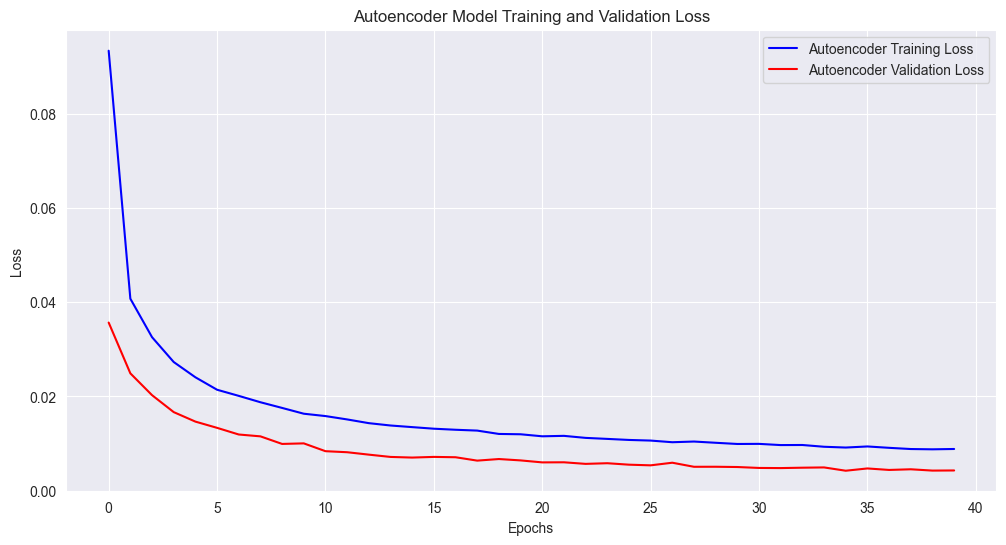

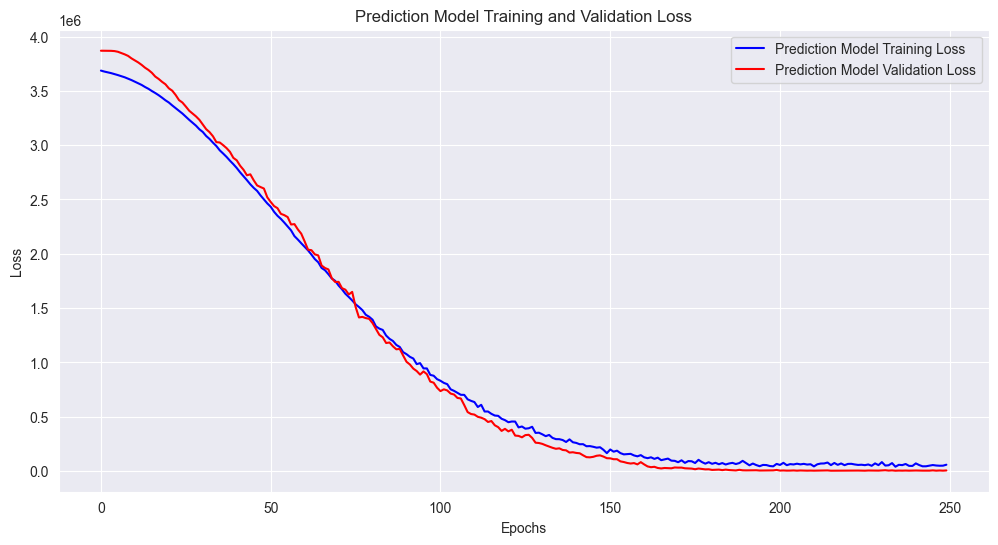

In [7]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define the autoencoder model creation function
def create_autoencoder_model(input_dim, encoding_dim=32):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(0.25)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dropout(0.25)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    # Autoencoder
    autoencoder = Model(input_layer, decoded)

    # Separate encoder model
    encoder = Model(input_layer, encoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return autoencoder, encoder

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the autoencoder
input_dim = X_train_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])

# Encode the data
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train a simple model to predict S&P using encoded features
prediction_model = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

prediction_model.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

prediction_history = prediction_model.fit(X_train_encoded, y_train,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = prediction_model.evaluate(X_test_encoded, y_test)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_predictions = prediction_model.predict(X_test_encoded)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Autoencoder Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Autoencoder Validation Loss', color='red')
plt.title('Autoencoder Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(prediction_history.history['loss'], label='Prediction Model Training Loss', color='blue')
plt.plot(prediction_history.history['val_loss'], label='Prediction Model Validation Loss', color='red')
plt.title('Prediction Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate models with MSE, Sharpe ratio, R2 and IC

Get the in-sample and out-of-sample R-Squared and MSE
The Information Coefficient (IC) measures the correlation between predicted and actual returns.
see: https://www.investopedia.com/terms/i/information-coefficient.asp
#### Sharpe Ratio
The Sharpe ratio is a measure of risk-adjusted return, calculated as the average return earned in excess of the risk-free rate per unit of volatility or total risk. 


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_proportion_correct(predictions, actuals):
    predictions = predictions.flatten()
    actuals = actuals
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    proportion_correct = np.mean(correct_predictions)
    return proportion_correct

def calculate_ic(proportion_correct):
    return (2 * proportion_correct) - 1

def calculate_sharpe_ratio(predictions, actuals, risk_free_rate=0):
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    strategy_returns = []
    for t in range(1, len(predictions)):
        if predictions[t-1] <= predictions[t] and actuals[t-1] <= actuals[t]:
            strategy_returns.append(actuals[t] - actuals[t-1])  # Long position
        elif predictions[t-1] > predictions[t] and actuals[t-1] > actuals[t]:
            strategy_returns.append(actuals[t-1] - actuals[t])  # Short position
        else:
            strategy_returns.append(0)  # No position
    
    strategy_returns = np.array(strategy_returns)
    
    mean_return = np.mean(strategy_returns)
    std_dev = np.std(strategy_returns)
    
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    
    return sharpe_ratio

# Evaluate in-sample predictions
ffnn_train_predictions = ffnn_model.predict(X_train)
lstm_train_predictions = lstm_model.predict(X_train_lstm_prepared)
cnn_train_predictions = cnn_model.predict(X_train)
autoencoder_train_predictions = prediction_model.predict(X_train_encoded)

# Ensure the length consistency of predictions and actuals
def ensure_length_consistency(predictions, actuals):
    min_length = min(len(predictions), len(actuals))
    return predictions[:min_length], actuals[:min_length]

# FFNN performance
ffnn_predictions, y_test = ensure_length_consistency(ffnn_predictions, y_test)
ffnn_in_sample_r2 = r2_score(y_train, ffnn_train_predictions)
ffnn_out_sample_r2 = r2_score(y_test, ffnn_predictions)
ffnn_in_sample_mse = mean_squared_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_in_sample_mae = mean_absolute_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mae = mean_absolute_error(y_test, ffnn_predictions)

# LSTM performance
lstm_predictions, y_test_lstm_prepared = ensure_length_consistency(lstm_predictions, y_test_lstm_prepared)
lstm_in_sample_r2 = r2_score(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mse = mean_squared_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mae = mean_absolute_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mae = mean_absolute_error(y_test_lstm_prepared, lstm_predictions)

# CNN performance
cnn_predictions, y_test = ensure_length_consistency(cnn_predictions, y_test)
cnn_in_sample_r2 = r2_score(y_train, cnn_train_predictions)
cnn_out_sample_r2 = r2_score(y_test, cnn_predictions)
cnn_in_sample_mse = mean_squared_error(y_train, cnn_train_predictions)
cnn_out_sample_mse = mean_squared_error(y_test, cnn_predictions)
cnn_in_sample_mae = mean_absolute_error(y_train, cnn_train_predictions)
cnn_out_sample_mae = mean_absolute_error(y_test, cnn_predictions)

# Autoencoder performance
autoencoder_predictions, y_test = ensure_length_consistency(autoencoder_predictions, y_test)
autoencoder_in_sample_r2 = r2_score(y_train, autoencoder_train_predictions)
autoencoder_out_sample_r2 = r2_score(y_test, autoencoder_predictions)
autoencoder_in_sample_mse = mean_squared_error(y_train, autoencoder_train_predictions)
autoencoder_out_sample_mse = mean_squared_error(y_test, autoencoder_predictions)
autoencoder_in_sample_mae = mean_absolute_error(y_train, autoencoder_train_predictions)
autoencoder_out_sample_mae = mean_absolute_error(y_test, autoencoder_predictions)

# Proportion correct and IC calculations
ffnn_in_sample_proportion_correct = calculate_proportion_correct(ffnn_train_predictions, y_train)
ffnn_out_sample_proportion_correct = calculate_proportion_correct(ffnn_predictions, y_test)
ffnn_in_sample_ic = calculate_ic(ffnn_in_sample_proportion_correct)
ffnn_out_sample_ic = calculate_ic(ffnn_out_sample_proportion_correct)

lstm_in_sample_proportion_correct = calculate_proportion_correct(lstm_train_predictions, y_train_lstm_prepared)
lstm_out_sample_proportion_correct = calculate_proportion_correct(lstm_predictions, y_test_lstm_prepared)
lstm_in_sample_ic = calculate_ic(lstm_in_sample_proportion_correct)
lstm_out_sample_ic = calculate_ic(lstm_out_sample_proportion_correct)

cnn_in_sample_proportion_correct = calculate_proportion_correct(cnn_train_predictions, y_train)
cnn_out_sample_proportion_correct = calculate_proportion_correct(cnn_predictions, y_test)
cnn_in_sample_ic = calculate_ic(cnn_in_sample_proportion_correct)
cnn_out_sample_ic = calculate_ic(cnn_out_sample_proportion_correct)

autoencoder_in_sample_proportion_correct = calculate_proportion_correct(autoencoder_train_predictions, y_train)
autoencoder_out_sample_proportion_correct = calculate_proportion_correct(autoencoder_predictions, y_test)
autoencoder_in_sample_ic = calculate_ic(autoencoder_in_sample_proportion_correct)
autoencoder_out_sample_ic = calculate_ic(autoencoder_out_sample_proportion_correct)

# Sharpe ratio calculations
ffnn_sharpe = calculate_sharpe_ratio(ffnn_predictions, y_test)
lstm_sharpe = calculate_sharpe_ratio(lstm_predictions, y_test_lstm_prepared)
cnn_sharpe = calculate_sharpe_ratio(cnn_predictions, y_test)
autoencoder_sharpe = calculate_sharpe_ratio(autoencoder_predictions, y_test)

# Create a table for all metrics
metrics_data = {
    "Model": ["FFNN", "LSTM", "CNN", "Autoencoder"],
    "In-sample MSE": [ffnn_in_sample_mse, lstm_in_sample_mse, cnn_in_sample_mse, autoencoder_in_sample_mse],
    "Out-sample MSE": [ffnn_out_sample_mse, lstm_out_sample_mse, cnn_out_sample_mse, autoencoder_out_sample_mse],
    "In-sample R2": [ffnn_in_sample_r2, lstm_in_sample_r2, cnn_in_sample_r2, autoencoder_in_sample_r2],
    "Out-sample R2": [ffnn_out_sample_r2, lstm_out_sample_r2, cnn_out_sample_r2, autoencoder_out_sample_r2],
    "In-sample MAE": [ffnn_in_sample_mae, lstm_in_sample_mae, cnn_in_sample_mae, autoencoder_in_sample_mae],
    "Out-sample MAE": [ffnn_out_sample_mae, lstm_out_sample_mae, cnn_out_sample_mae, autoencoder_out_sample_mae],
    "In-sample IC": [ffnn_in_sample_ic, lstm_in_sample_ic, cnn_in_sample_ic, autoencoder_in_sample_ic],
    "Out-sample IC": [ffnn_out_sample_ic, lstm_out_sample_ic, cnn_out_sample_ic, autoencoder_out_sample_ic],
    "Sharpe Ratio": [ffnn_sharpe, lstm_sharpe, cnn_sharpe, autoencoder_sharpe]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample MAE,Out-sample MAE,In-sample IC,Out-sample IC,Sharpe Ratio
0,FFNN,5.856852e+03,7031.923111,0.995492,0.995255,51.254709,54.451457,0.936213,0.952128,1.079614
1,LSTM,1.046253e+04,14492.460299,0.992125,0.989309,76.984512,84.790344,0.925184,0.903743,1.118886
2,CNN,6.108756e+06,7226.887505,-3.702273,0.995124,1387.380525,57.554080,0.799336,0.909574,1.076980
3,Autoencoder,2.532459e+06,8592.010678,-0.949384,0.994203,1414.549583,68.454938,0.234551,0.962766,1.079814


## Show the Actual vs. Predicted Values
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

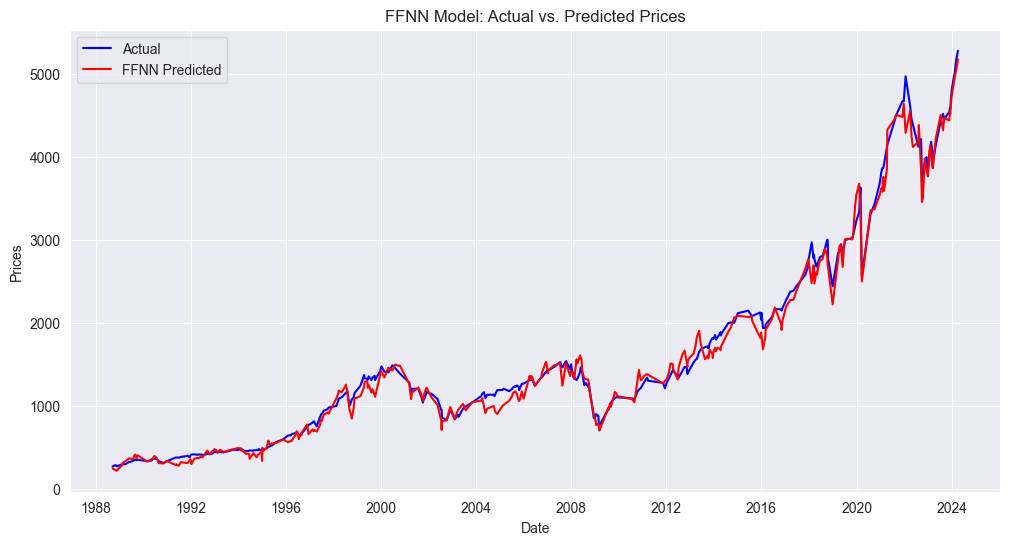

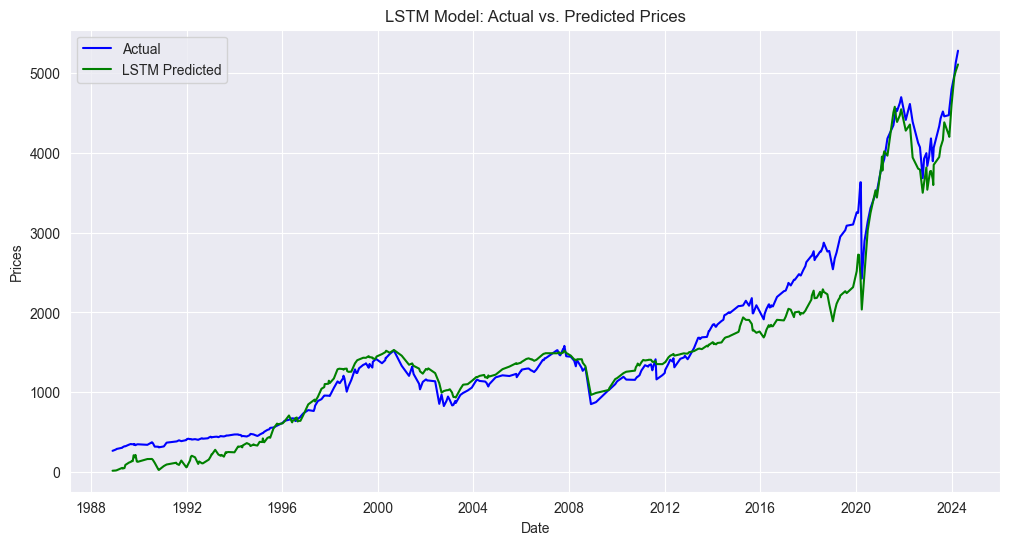

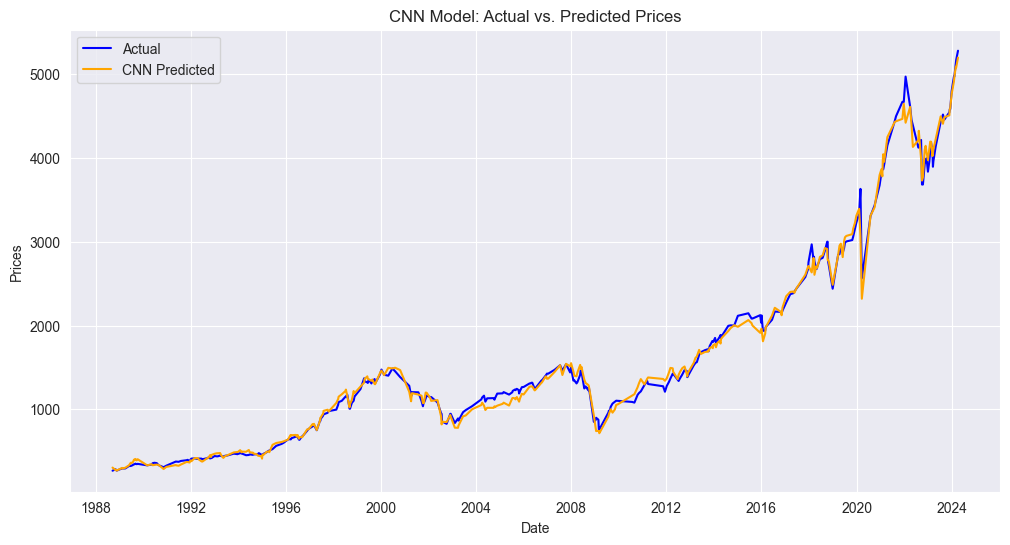

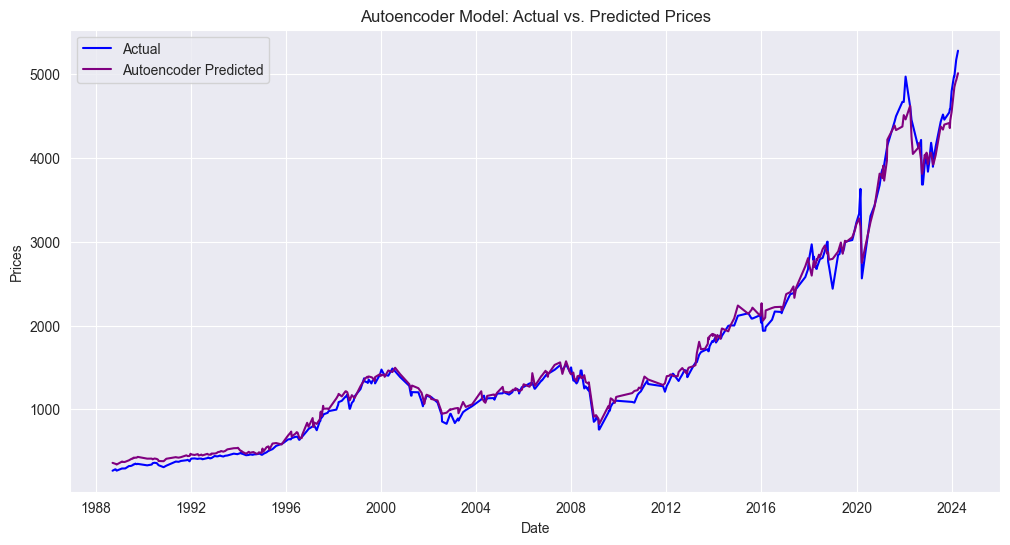

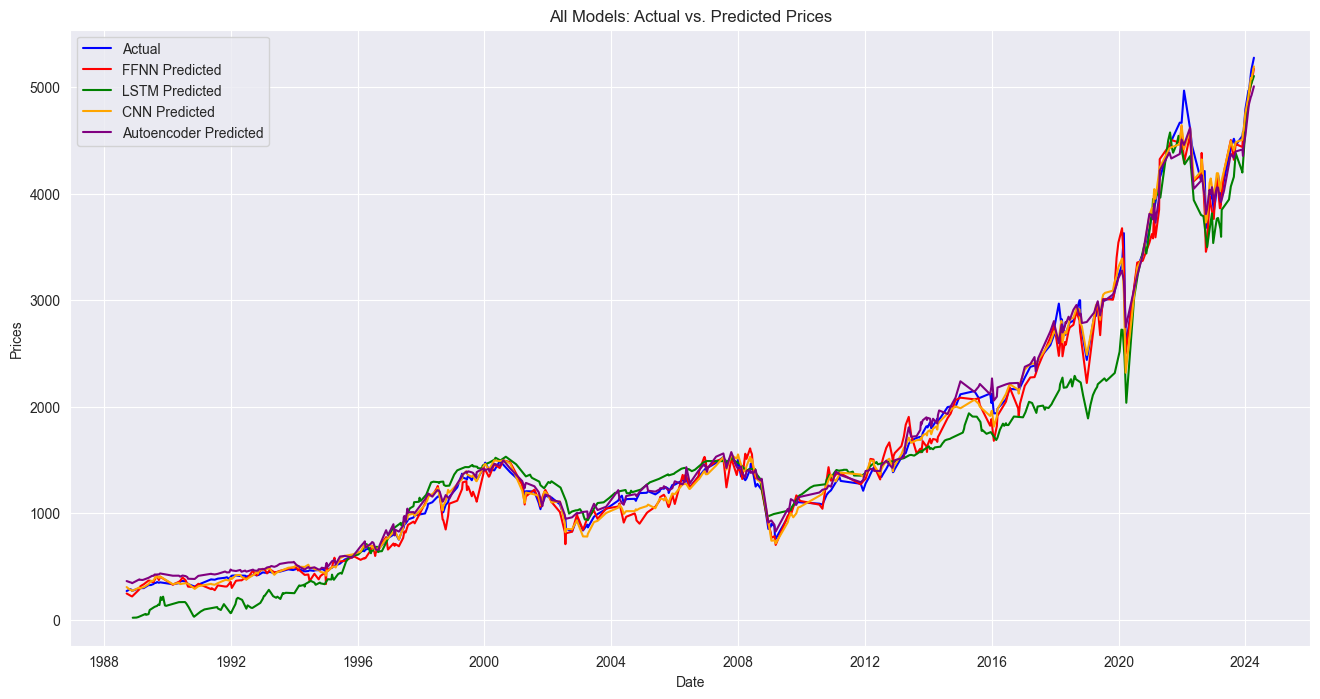

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Create a Date column from 'day', 'month', and 'year'
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Ensure all predictions and actuals are 1-dimensional
y_test_series = pd.Series(y_test.squeeze(), index=y_test.index, name='Actual')
y_test_lstm_series = pd.Series(y_test_lstm_prepared.squeeze(), index=y_test_lstm_prepared, name='Actual')
ffnn_predictions_flat = ffnn_predictions.flatten()
lstm_predictions_flat = lstm_predictions.flatten()
cnn_predictions_flat = cnn_predictions.flatten()
autoencoder_predictions_flat = autoencoder_predictions.flatten()

# Create DataFrame for y_test and ffnn_predictions
ffnn_test_df = pd.DataFrame({
    'Actual': y_test_series.values,
    'FFNN_Predicted': ffnn_predictions_flat
}, index=y_test_series.index)

# Merge ffnn_test_df with the original data using the index
ffnn_merged_df = data.join(ffnn_test_df, how='inner')

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['Actual'], label='Actual', color='blue')
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['FFNN_Predicted'], label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# LSTM plot
lstm_test_df = pd.DataFrame({
    'Date_lstm': data.loc[test_indices, 'Date'].values,
    'Actual_lstm': y_test_lstm_prepared,
    'LSTM_Predicted': lstm_predictions.flatten()
}, index=test_indices)

lstm_merged_df = data.join(lstm_test_df, how='inner', lsuffix='_orig', rsuffix='_lstm')

plt.figure(figsize=(12, 6))
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['Actual_lstm'], label='Actual', color='blue')
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['LSTM_Predicted'], label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# CNN plot
cnn_test_df = pd.DataFrame({
    'Date_cnn': data.loc[y_test.index, 'Date'].values,
    'Actual_cnn': y_test.values,
    'CNN_Predicted': cnn_predictions.flatten()
}, index=y_test.index)

cnn_merged_df = data.join(cnn_test_df, how='inner', lsuffix='_orig', rsuffix='_cnn')

plt.figure(figsize=(12, 6))
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['Actual_cnn'], label='Actual', color='blue')
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['CNN_Predicted'], label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Autoencoder plot
autoencoder_test_df = pd.DataFrame({
    'Date_autoencoder': data.loc[y_test.index, 'Date'].values,
    'Actual_autoencoder': y_test.values,
    'Autoencoder_Predicted': autoencoder_predictions_flat
}, index=y_test.index)

autoencoder_merged_df = data.join(autoencoder_test_df, how='inner', lsuffix='_orig', rsuffix='_autoencoder')

plt.figure(figsize=(12, 6))
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Actual_autoencoder'], label='Actual', color='blue')
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Autoencoder_Predicted'], label='Autoencoder Predicted', color='purple')
plt.title('Autoencoder Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Combined plot of all models
plt.figure(figsize=(16, 8))
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['Actual'], label='Actual', color='blue')
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['FFNN_Predicted'], label='FFNN Predicted', color='red')
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['LSTM_Predicted'], label='LSTM Predicted', color='green')
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['CNN_Predicted'], label='CNN Predicted', color='orange')
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Autoencoder_Predicted'], label='Autoencoder Predicted', color='purple')
plt.title('All Models: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Interpretation of Results:
The charts show the actual vs. predicted values for each model (FFNN, LSTM, CNN). The models' predictions are compared to the actual S&P 500 index values. The visualizations help understand the models' performance in predicting the stock market movements. The LSTM plot look a bit strange due to unique train test split we implemented to keep the data sequential.

# Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

In [36]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=200, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=300, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)



Epoch 1/200


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3781339.0000 - val_loss: 3743030.5000
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3420935.7500 - val_loss: 3463612.0000
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3178222.7500 - val_loss: 2964782.7500
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2654896.7500 - val_loss: 2303880.0000
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1870024.3750 - val_loss: 1650336.1250
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1591685.3750 - val_loss: 1284237.0000
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1325322.0000 - val_loss: 1155226.3750
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1217626.8750 - val_loss: 1080512.6250
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1186668.3750 - val_loss: 1020176.5000
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1126503.8750 - val_loss: 966441.0000
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3708632.2500 - val_loss: 3738903.5000
Epoch 2/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3510243.0000 - val_loss: 3452183.7500
Epoch 3/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3167037.0000 - val_loss: 2952657.5000
Epoch 4/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2829840.5000 - val_loss: 2223597.2500
Epoch 5/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1831926.6250 - val_loss: 1445058.5000
Epoch 6/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1361375.0000 - val_loss: 825702.2500
Epoch 7/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 767680.2500 - val_loss: 549607.4375
Epoch 8/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 541481.2500 - val_loss: 435306.2500
Epoch 9/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 493195.0625 - val_loss: 359088.7188
Epoch 10/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 445003.9688 - val_loss: 284726.7812
Epoch 11/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

# LSTM

In [41]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, _, X_test_macro_prepared, y_test_macro_prepared, _ = custom_train_test_split_with_indices(features_macro_scaled, target_macro)


lstm_model_macro = create_lstm_model((X_train_macro_prepared.shape[1], X_train_macro_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_prepared, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_prepared, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_prepared)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

# Split the data using the custom function

X_train_market_prepared, y_train_market_prepared, _ , X_test_market_prepared, y_test_market_prepared, _ = custom_train_test_split_with_indices(features_market_scaled, target_market)


lstm_model_market = create_lstm_model((X_train_market_prepared.shape[1], X_train_market_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_prepared, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_prepared, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_prepared)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)


Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3577354.2500 - val_loss: 3938270.2500
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3784210.2500 - val_loss: 3808581.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3755826.5000 - val_loss: 3709199.7500
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3520267.2500 - val_loss: 3630949.5000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3609637.5000 - val_loss: 3221711.2500
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3149819.2500 - val_loss: 3186205.7500
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2834339.7500 - val_loss: 3135270.5000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2654763.5000 - val_loss: 2842657.5000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2321476.2500 - val_loss: 687342.7500
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1863584.2500 - val_loss: 2226099.2500
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3690692.5000 - val_loss: 3924650.7500
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3805350.2500 - val_loss: 3868536.2500
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3752843.0000 - val_loss: 3749234.2500
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3786024.7500 - val_loss: 3385511.7500
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3605766.7500 - val_loss: 3444058.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3388613.0000 - val_loss: 2391873.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2902547.5000 - val_loss: 2585724.2500
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2432537.5000 - val_loss: 2117556.2500
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2146952.7500 - val_loss: 2359659.5000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1699042.5000 - val_loss: 1754625.8750
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

# CNN

In [43]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)


Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3421546.5000 - val_loss: 1389052.8750
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1420564.8750 - val_loss: 1306957.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1460615.3750 - val_loss: 1173186.7500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1317363.7500 - val_loss: 1035421.5625
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1050303.3750 - val_loss: 879713.3750
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 926251.6875 - val_loss: 738618.5625
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 837369.5000 - val_loss: 659575.1250
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 793407.9375 - val_loss: 612667.8750
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 810140.6875 - val_loss: 582108.9375
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 697340.0625 - val_loss: 538116.0625
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3583372.7500 - val_loss: 772553.5625
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 476579.3125 - val_loss: 239261.3594
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 240969.4375 - val_loss: 106332.4609
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104590.9844 - val_loss: 55807.7852
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62441.0625 - val_loss: 50104.8359
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58672.3516 - val_loss: 49890.1602
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52599.5938 - val_loss: 42471.2578
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46426.9297 - val_loss: 39182.9375
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43775.7188 - val_loss: 36299.4336
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39706.6406 - val_loss: 32765.0801
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35556.7461 - val_loss: 

# Autoencoder

In [39]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']

# scaler_macro = MinMaxScaler(feature_range=(0, 1))
# features_macro_scaled = scaler_macro.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro, target_macro, test_size=0.3, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_macro_scaled = scaler.fit_transform(X_train_macro)
X_test_macro_scaled = scaler.transform(X_test_macro)

# Create and train the autoencoder
input_dim = X_train_macro_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_macro_scaled, X_train_macro_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])


# Encode the data
X_train_macro_encoded = encoder.predict(X_train_macro_scaled)
X_test_macro_encoded = encoder.predict(X_test_macro_scaled)

# Train a simple model to predict S&P using encoded features
prediction_model = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

prediction_model.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler

prediction_history = prediction_model.fit(X_train_macro_encoded, y_train_macro,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = prediction_model.evaluate(X_test_macro_encoded, y_test_macro)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_macro_predictions = prediction_model.predict(X_test_macro_encoded)

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market, target_market, test_size=0.3, random_state=42)

# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_market_scaled = scaler.fit_transform(X_train_market)
X_test_market_scaled = scaler.transform(X_test_market)

# Create and train the autoencoder
input_dim = X_train_market_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_market_scaled, X_train_market_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])


# Encode the data
X_train_market_encoded = encoder.predict(X_train_market_scaled)
X_test_market_encoded = encoder.predict(X_test_market_scaled)

# Train a simple model to predict S&P using encoded features
prediction_model = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

prediction_model.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler

prediction_history = prediction_model.fit(X_train_market_encoded, y_train_market,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = prediction_model.evaluate(X_test_market_encoded, y_test_market)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_market_predictions = prediction_model.predict(X_test_market_encoded)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1872 - val_loss: 0.0374
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428 - val_loss: 0.0160
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.0085
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - val_loss: 0.0073
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185 - val_loss: 0.0064
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0050
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0043
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0030
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0034
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0039
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0027
Epoch 12/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_lo

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3800657.2500 - val_loss: 3827688.0000
Epoch 2/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3571491.7500 - val_loss: 3825088.2500
Epoch 3/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3567568.7500 - val_loss: 3823328.2500
Epoch 4/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4132396.2500 - val_loss: 3822964.0000
Epoch 5/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3648014.2500 - val_loss: 3825390.2500
Epoch 6/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3747401.0000 - val_loss: 3831641.7500
Epoch 7/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3405156.2500 - val_loss: 3837405.5000
Epoch 8/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3622007.0000 - val_loss: 3844322.7500
Epoch 9/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3710236.0000 - val_loss: 3845911.2500
Epoch 10/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3702166.7500 - val_loss: 3841740.7500
Epoch 11/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3579777.7500 - val_loss: 3828561.7500
Epoch 2/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3577596.0000 - val_loss: 3827648.5000
Epoch 3/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3812927.7500 - val_loss: 3828061.0000
Epoch 4/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3783812.7500 - val_loss: 3829596.7500
Epoch 5/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3689231.2500 - val_loss: 3828844.0000
Epoch 6/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3411460.0000 - val_loss: 3828480.5000
Epoch 7/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3863538.0000 - val_loss: 3824484.0000
Epoch 8/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3959065.0000 - val_loss: 3820515.0000
Epoch 9/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3404979.7500 - val_loss: 3814003.2500
Epoch 10/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3544727.0000 - val_loss: 3803214.2500
Epoch 11/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

### Step 5: Analyze Hypotheses with In-sample and Out-of-sample Performance
We evaluate the in-sample and out-of-sample performance of different models (FFNN, LSTM, CNN) on predicting the S&P 500 index using macroeconomic and market signals. Each model's performance is assessed using Mean Squared Error (MSE), R-squared (R²), and Information Coefficient (IC) metrics. The LSTM model's architecture is visualized, incorporating dropout and batch normalization for regularization. Training and validation losses are plotted to monitor the model's performance.

#### Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample IC,Out-sample IC,Sharpe Ratio
0,FFNN Macro,5.573880e+04,63776.862001,0.957085,0.955142,0.857251,0.819149,1.022419
1,FFNN Market,4.602823e+03,6096.640756,0.996456,0.995712,0.945330,0.946809,1.043538
2,LSTM Macro,1.967759e+04,21184.684972,0.985190,0.984372,0.898464,0.887701,1.122359
3,LSTM Market,1.870927e+05,195571.578221,0.859183,0.855730,0.890448,0.898396,1.119938
4,CNN Macro,9.797118e+04,113949.814739,0.924569,0.919852,0.810175,0.758865,1.005553
5,CNN Market,4.922167e+03,6214.495284,0.996210,0.995629,0.940774,0.960993,1.044397
6,Autoencoder Macro,3.716764e+06,22131.479130,-1.861647,0.984433,-0.061503,0.897163,1.036660
7,Autoencoder Market,1.661567e+06,12901.155124,-0.279290,0.990926,-0.125285,0.939716,1.041952


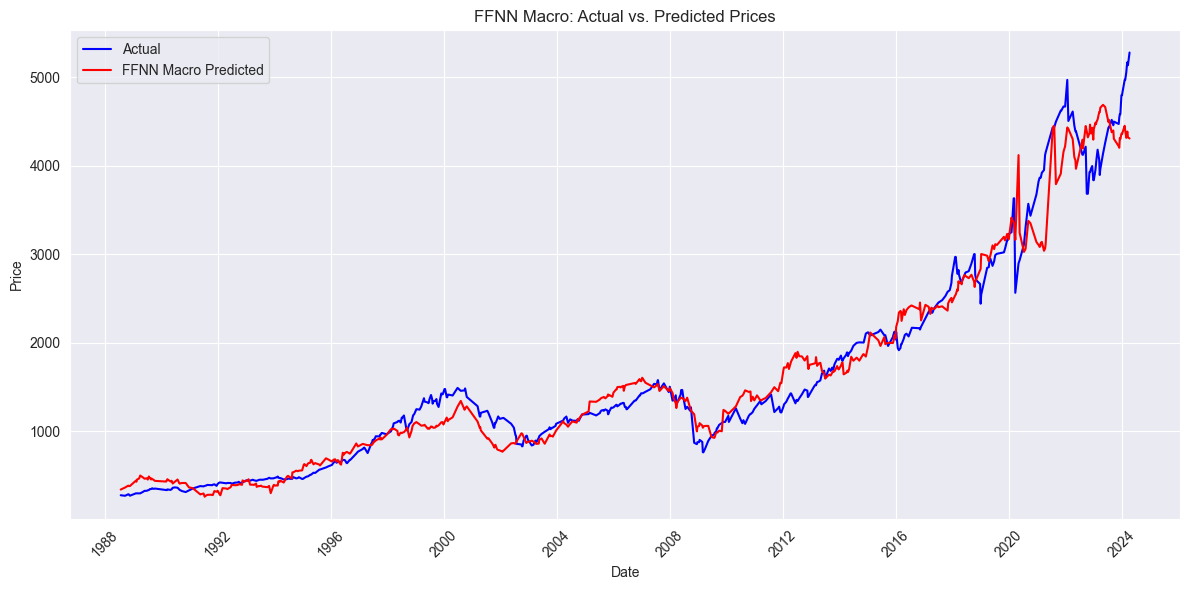

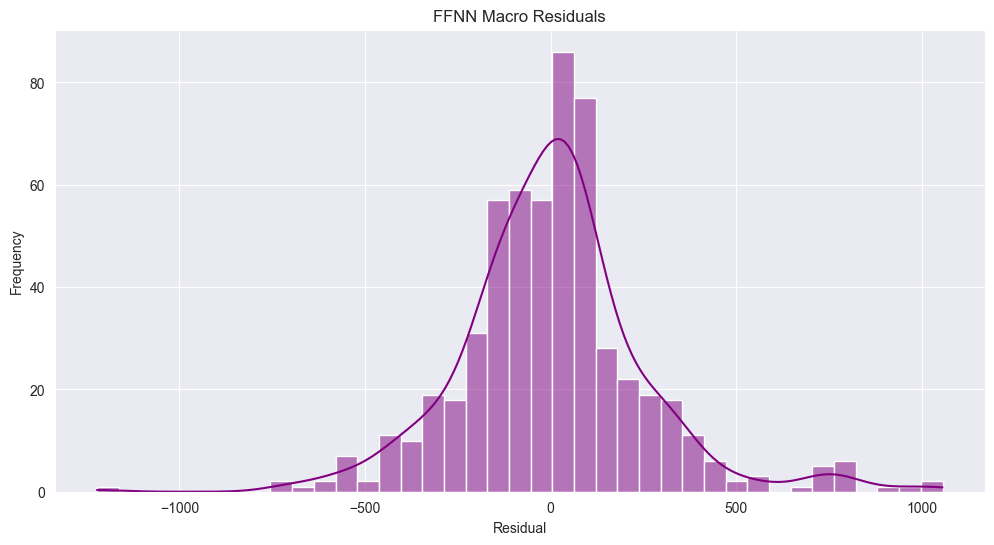

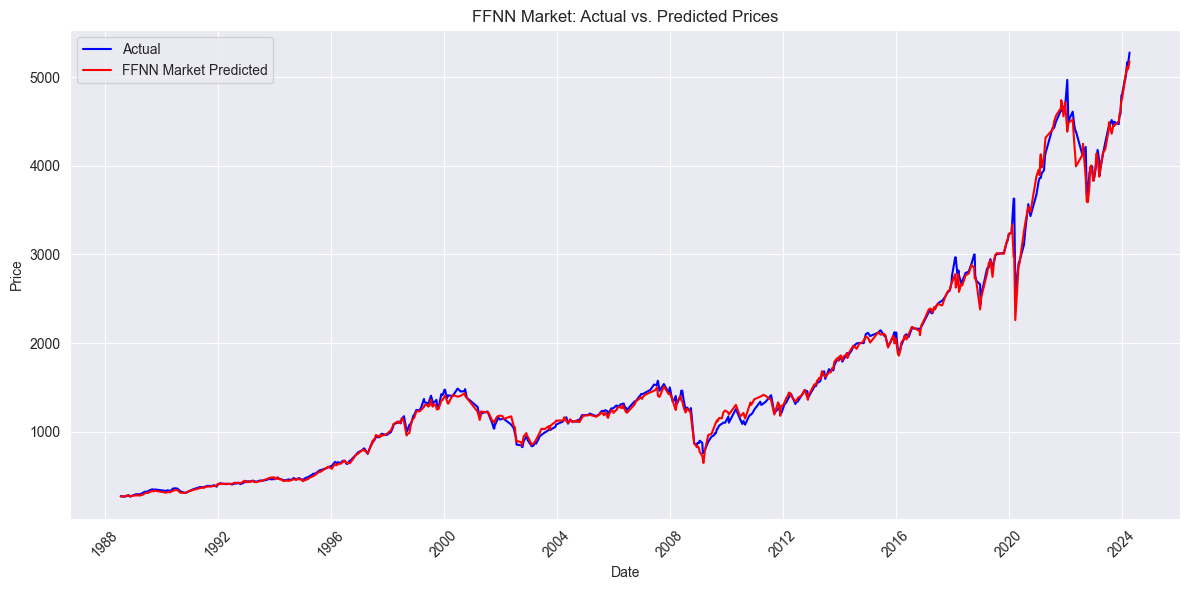

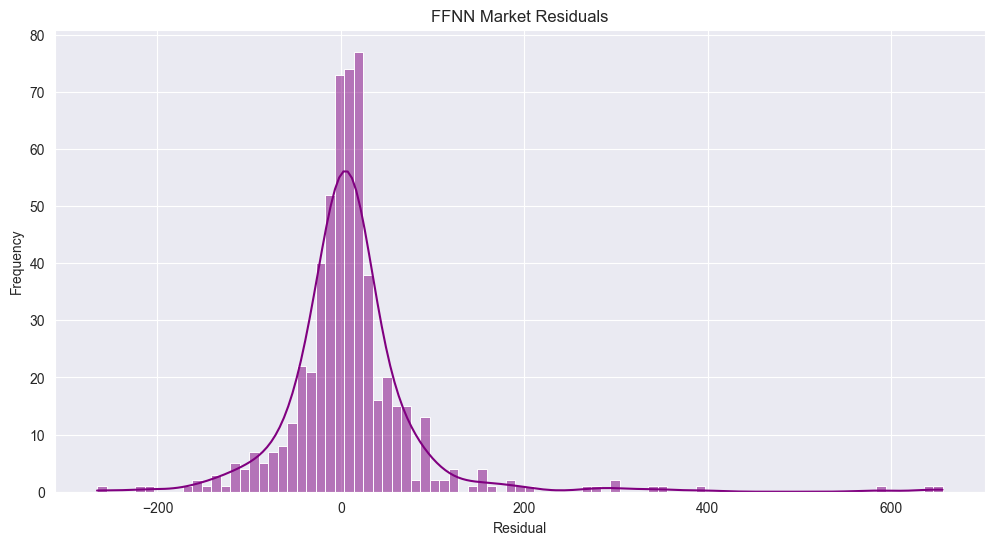

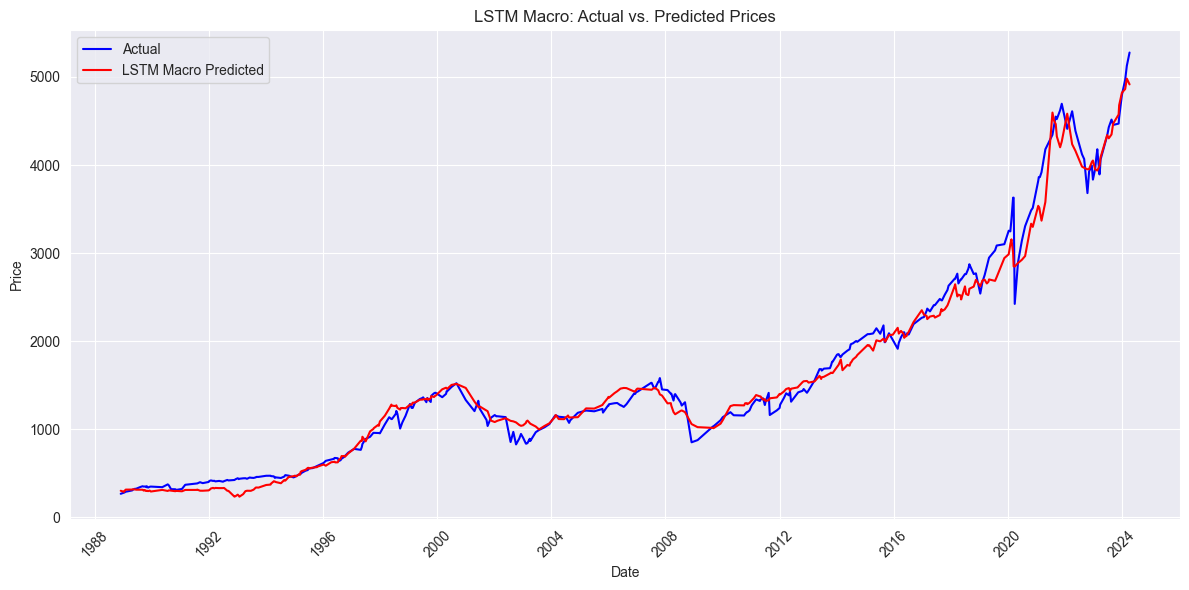

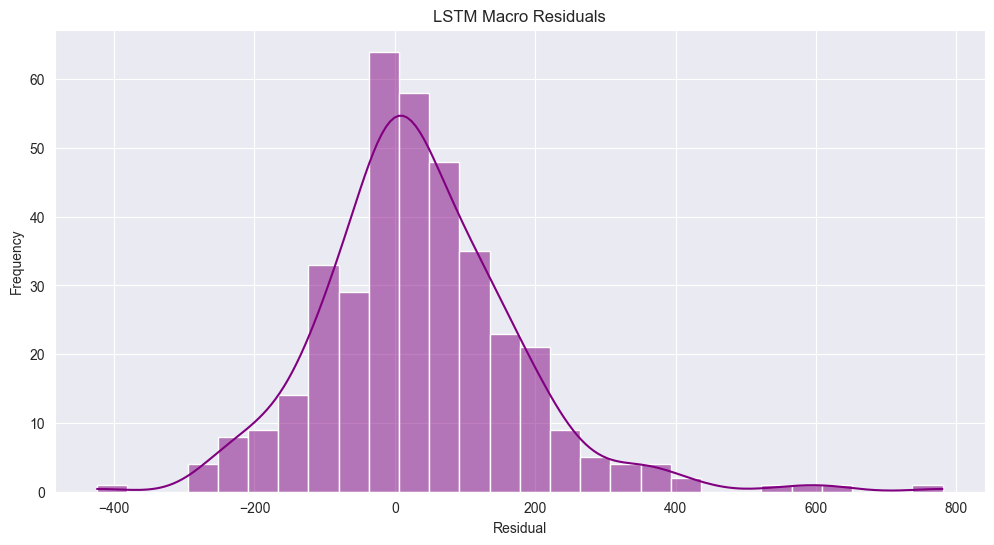

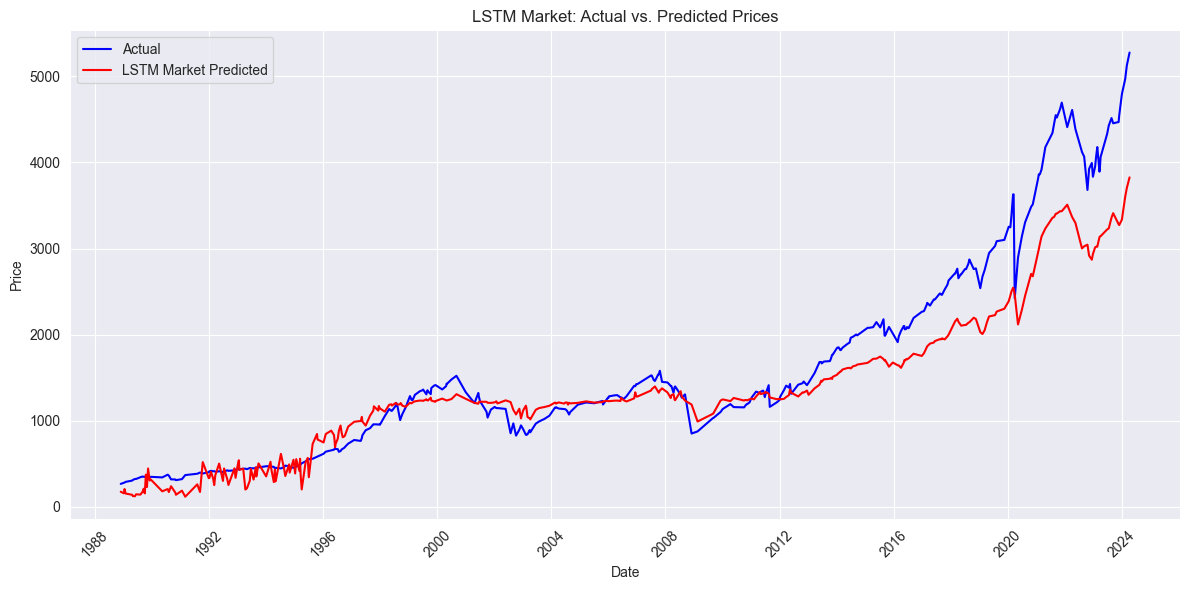

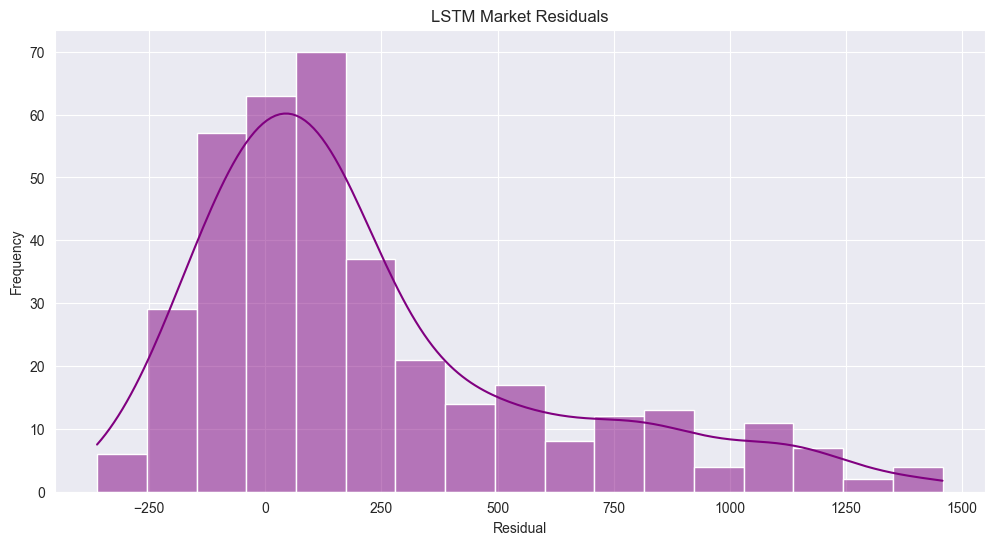

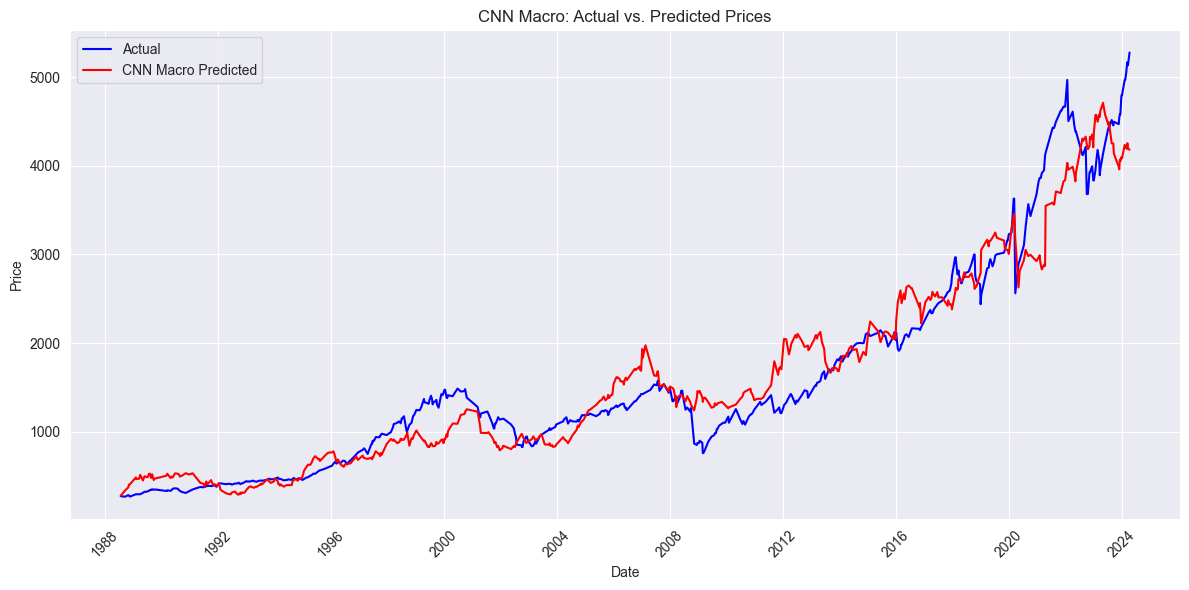

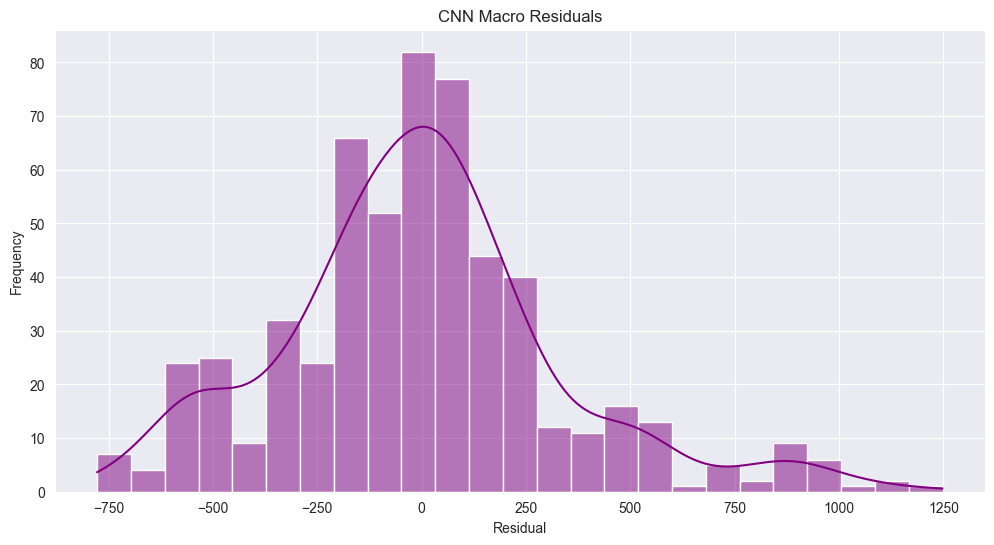

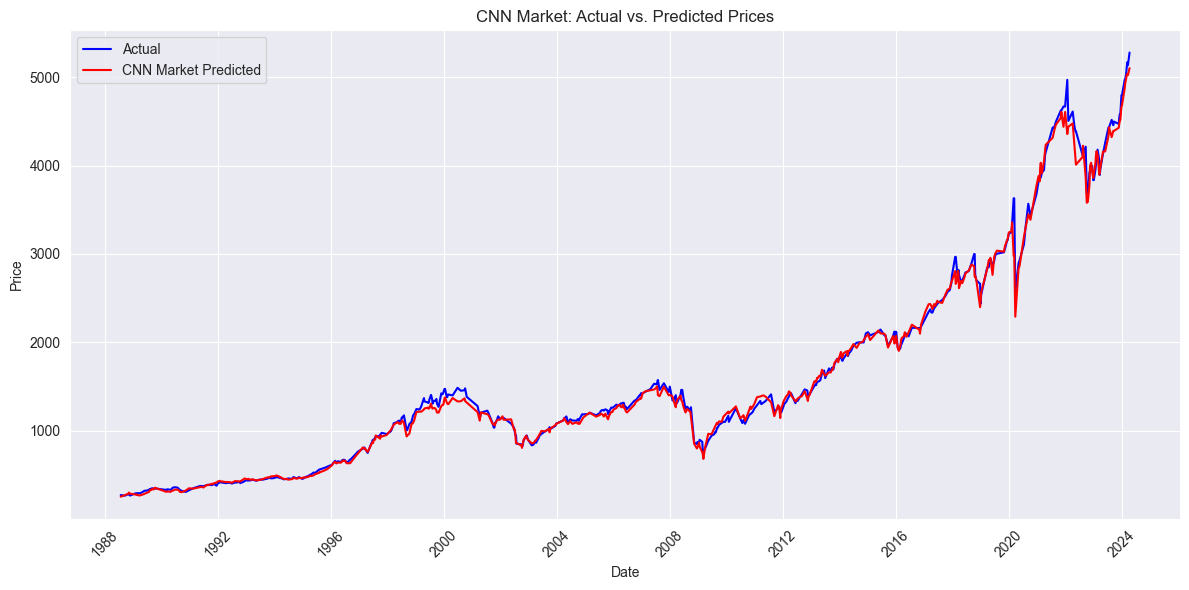

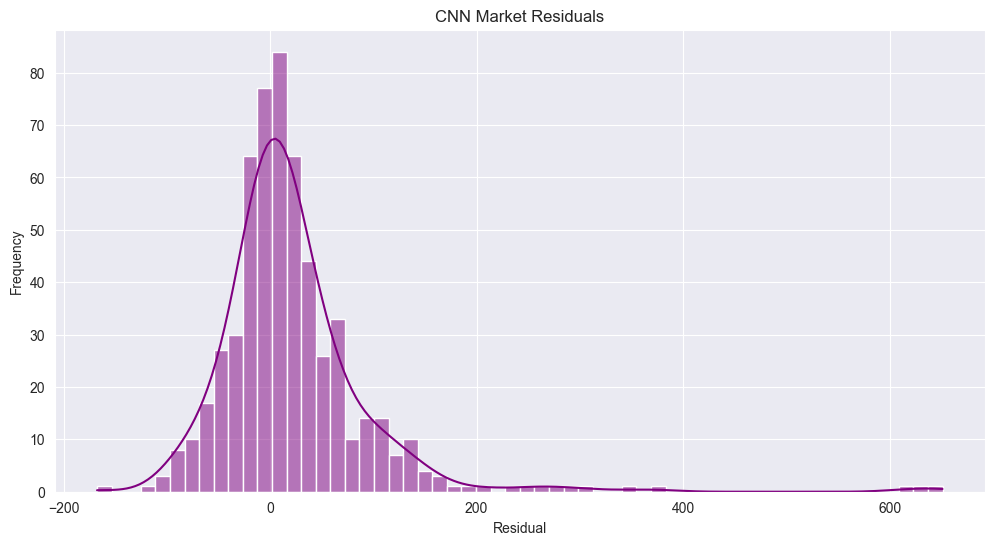

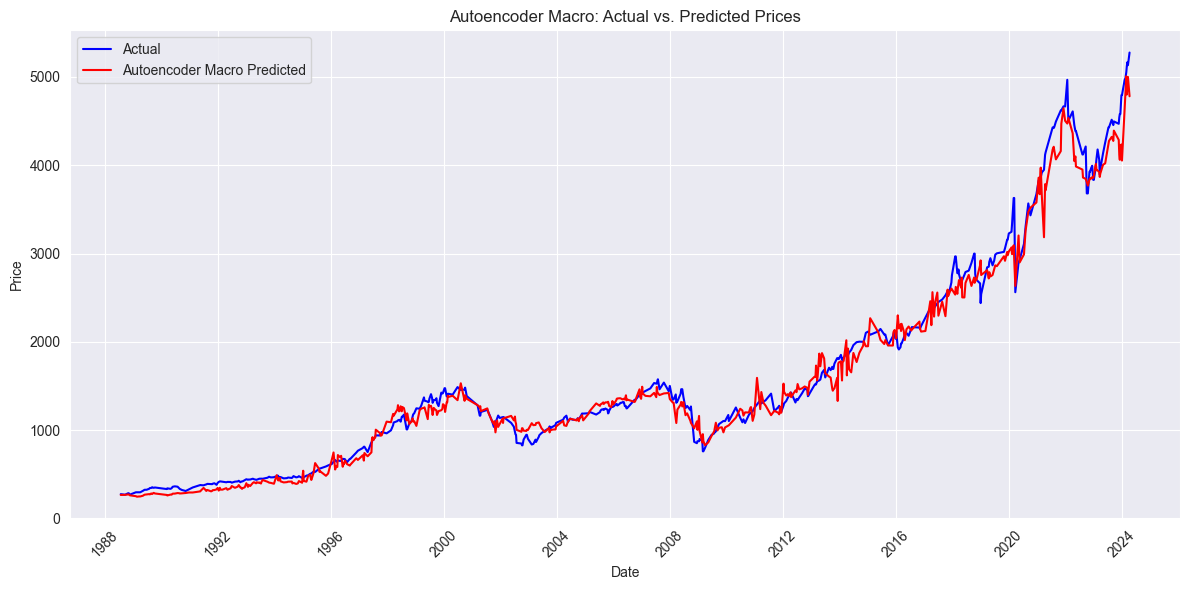

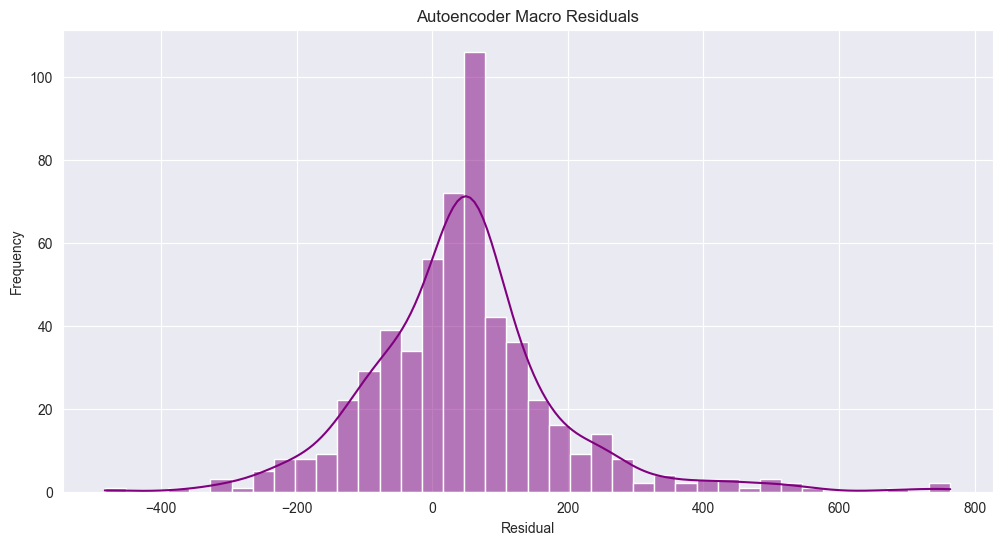

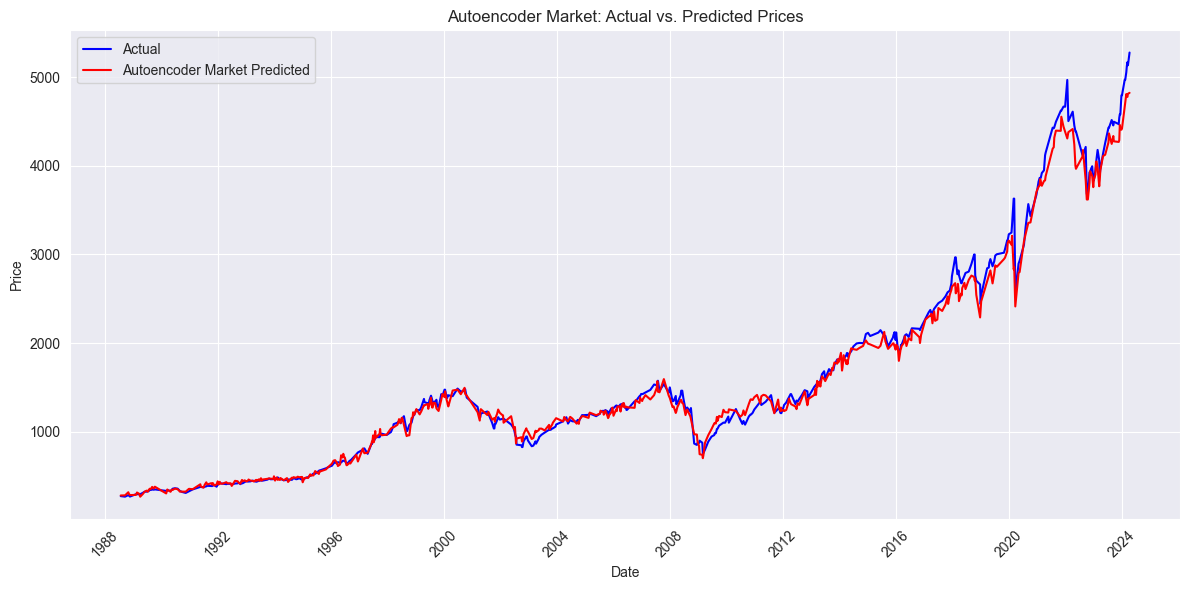

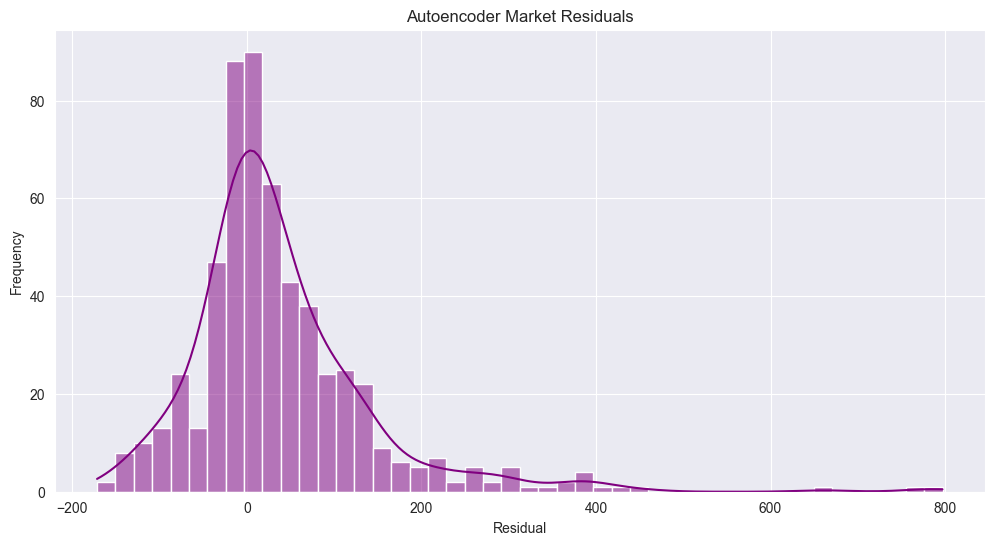

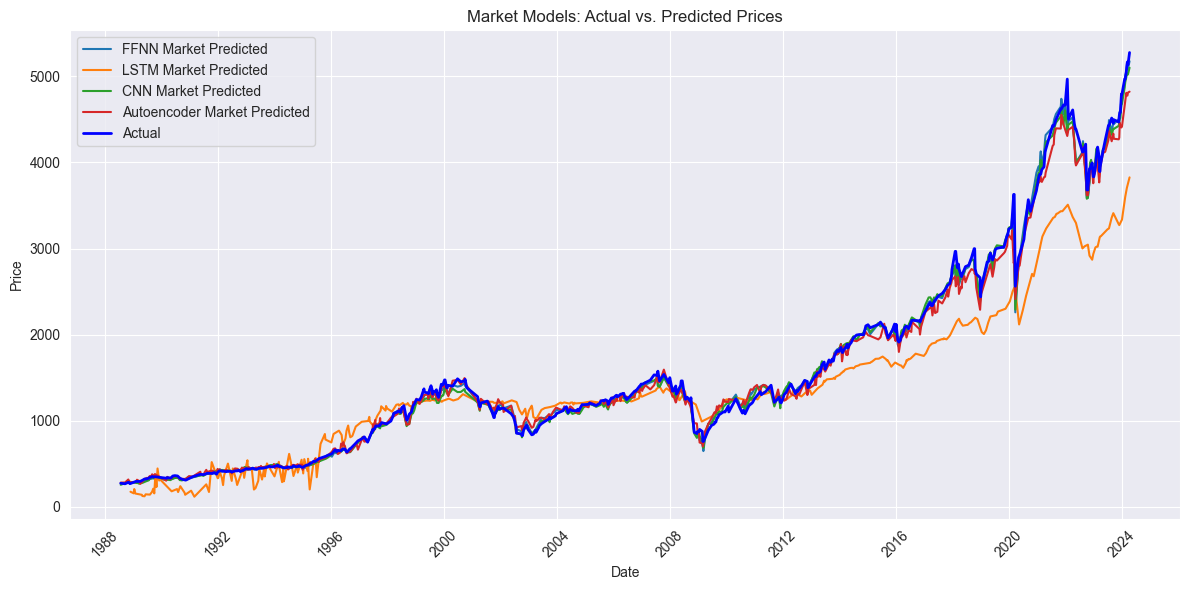

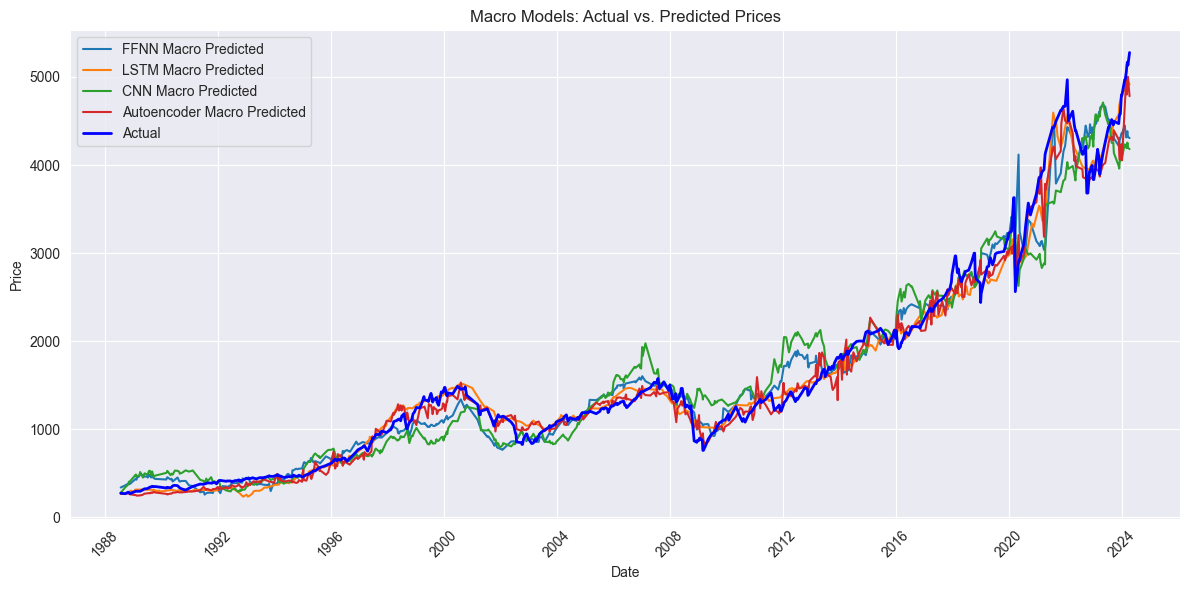

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import pandas as pd

# In sample predictions
ffnn_macro_train_predictions = ffnn_model_macro.predict(X_train_macro)
lstm_macro_train_predictions = lstm_model_macro.predict(X_train_macro_prepared)
cnn_macro_train_predictions = cnn_model_macro.predict(X_train_macro)
autoencoder_macro_train_predictions = prediction_model_macro.predict(X_train_macro_encoded)

ffnn_market_train_predictions = ffnn_model_market.predict(X_train_market)
lstm_market_train_predictions = lstm_model_market.predict(X_train_market_prepared)
cnn_market_train_predictions = cnn_model_market.predict(X_train_market)
autoencoder_market_train_predictions = prediction_model_market.predict(X_train_market_encoded)

# Function to evaluate and compare models
def evaluate_model_performance(model_name, y_train, y_test, train_predictions, test_predictions):
    # Calculate metrics
    in_sample_mse = mean_squared_error(y_train, train_predictions)
    out_sample_mse = mean_squared_error(y_test, test_predictions)
    in_sample_r2 = r2_score(y_train, train_predictions)
    out_sample_r2 = r2_score(y_test, test_predictions)
    
    # Calculate proportion correct and IC
    in_sample_proportion_correct = calculate_proportion_correct(train_predictions, y_train)
    out_sample_proportion_correct = calculate_proportion_correct(test_predictions, y_test)
    in_sample_ic = calculate_ic(in_sample_proportion_correct)
    out_sample_ic = calculate_ic(out_sample_proportion_correct)
    
    sharpe_ratio = calculate_sharpe_ratio(test_predictions, y_test)
    
    return {
        "Model": model_name,
        "In-sample MSE": in_sample_mse,
        "Out-sample MSE": out_sample_mse,
        "In-sample R2": in_sample_r2,
        "Out-sample R2": out_sample_r2,
        "In-sample IC": in_sample_ic,
        "Out-sample IC": out_sample_ic,
        "Sharpe Ratio": sharpe_ratio
    }

# Evaluate and compare all models
models_performance = []

# FFNN Macro
models_performance.append(evaluate_model_performance("FFNN Macro", y_train_macro.values, y_test_macro.values, ffnn_macro_train_predictions, ffnn_macro_predictions))

# FFNN Market
models_performance.append(evaluate_model_performance("FFNN Market", y_train_market.values, y_test_market.values, ffnn_market_train_predictions, ffnn_market_predictions))

# LSTM Macro
models_performance.append(evaluate_model_performance("LSTM Macro", y_train_macro_prepared, y_test_macro_prepared, lstm_macro_train_predictions, lstm_macro_predictions))

# LSTM Market
models_performance.append(evaluate_model_performance("LSTM Market", y_train_market_prepared, y_test_market_prepared, lstm_market_train_predictions, lstm_market_predictions))

# CNN Macro
models_performance.append(evaluate_model_performance("CNN Macro", y_train_macro.values, y_test_macro.values, cnn_macro_train_predictions, cnn_macro_predictions))

# CNN Market
models_performance.append(evaluate_model_performance("CNN Market", y_train_market.values, y_test_market.values, cnn_market_train_predictions, cnn_market_predictions))

# Autoencoder Macro
models_performance.append(evaluate_model_performance("Autoencoder Macro", y_train_macro.values, y_test_macro.values, autoencoder_macro_train_predictions, autoencoder_macro_predictions))

# Autoencoder Market
models_performance.append(evaluate_model_performance("Autoencoder Market", y_train_market.values, y_test_market.values, autoencoder_market_train_predictions, autoencoder_market_predictions))

# Convert to DataFrame for easy visualization
performance_df = pd.DataFrame(models_performance)
display(performance_df)

# Function to plot Actual vs. Predicted and Residuals
def plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions, dates):
    min_length = min(len(y_test), len(predictions), len(dates))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]
    dates = dates[:min_length]

    # Create a DataFrame with dates, actual values, and predictions
    df = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Predicted': predictions.flatten()
    })
    df = df.sort_values('Date')

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue')
    plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted', color='red')
    plt.title(f'{model_name}: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    residuals = df['Actual'] - df['Predicted']
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f'{model_name} Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

# Plot for each model
for model in models_performance:
    model_name = model["Model"]
    if "Macro" in model_name:
        if "LSTM" in model_name:
            y_test = y_test_macro_prepared
            predictions = lstm_macro_predictions
            dates = data.loc[test_indices, 'Date']
        elif "Autoencoder" in model_name:
            y_test = y_test_macro
            predictions = autoencoder_macro_predictions
            dates = data.loc[y_test_macro.index, 'Date']
        else:
            y_test = y_test_macro.values
            predictions = cnn_macro_predictions if model_name == "CNN Macro" else ffnn_macro_predictions
            dates = data.loc[y_test_macro.index, 'Date']
    else:
        if "LSTM" in model_name:
            y_test = y_test_market_prepared
            predictions = lstm_market_predictions
            dates = data.loc[test_indices, 'Date']
        elif "Autoencoder" in model_name:
            y_test = y_test_market
            predictions = autoencoder_market_predictions
            dates = data.loc[y_test_market.index, 'Date']
        else:
            y_test = y_test_market.values
            predictions = cnn_market_predictions if model_name == "CNN Market" else ffnn_market_predictions
            dates = data.loc[y_test_market.index, 'Date']

    plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions, dates)

# Combined plot for all market predictions
def plot_combined_actual_vs_predicted_market(models_performance, data):
    plt.figure(figsize=(12, 6))
    for model in models_performance:
        model_name = model["Model"]
        if "Market" in model_name:
            if "LSTM" in model_name:
                y_test = y_test_market_prepared
                predictions = lstm_market_predictions
                dates = data.loc[test_indices, 'Date']
            elif "Autoencoder" in model_name:
                y_test = y_test_market
                predictions = autoencoder_market_predictions
                dates = data.loc[y_test_market.index, 'Date']
            else:
                y_test = y_test_market.values
                predictions = cnn_market_predictions if model_name == "CNN Market" else ffnn_market_predictions
                dates = data.loc[y_test_market.index, 'Date']

            min_length = min(len(y_test), len(predictions), len(dates))
            y_test = y_test[:min_length]
            predictions = predictions[:min_length]
            dates = dates[:min_length]

            # Create a DataFrame with dates, actual values, and predictions
            df = pd.DataFrame({
                'Date': dates,
                'Actual': y_test,
                'Predicted': predictions.flatten()
            })
            df = df.sort_values('Date')

            plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted')
    
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.title('Market Models: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Combined plot for all macro predictions
def plot_combined_actual_vs_predicted_macro(models_performance, data):
    plt.figure(figsize=(12, 6))
    for model in models_performance:
        model_name = model["Model"]
        if "Macro" in model_name:
            if "LSTM" in model_name:
                y_test = y_test_macro_prepared
                predictions = lstm_macro_predictions
                dates = data.loc[test_indices, 'Date']
            elif "Autoencoder" in model_name:
                y_test = y_test_macro
                predictions = autoencoder_macro_predictions
                dates = data.loc[y_test_macro.index, 'Date']
            else:
                y_test = y_test_macro.values
                predictions = cnn_macro_predictions if model_name == "CNN Macro" else ffnn_macro_predictions
                dates = data.loc[y_test_macro.index, 'Date']

            min_length = min(len(y_test), len(predictions), len(dates))
            y_test = y_test[:min_length]
            predictions = predictions[:min_length]
            dates = dates[:min_length]

            # Create a DataFrame with dates, actual values, and predictions
            df = pd.DataFrame({
                'Date': dates,
                'Actual': y_test,
                'Predicted': predictions.flatten()
            })
            df = df.sort_values('Date')

            plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted')
    
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.title('Macro Models: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_combined_actual_vs_predicted_market(models_performance, data)
plot_combined_actual_vs_predicted_macro(models_performance, data)


## Evaluation
Best Models: FFNN Market and CNN Market show the best overall performance.
Moderate Models: CNN Macro and FFNN Macro have moderate performance with better directional accuracy (IC).
Poor Model: LSTM Macro performs poorly with negative R² and low IC.

### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!